<a href="https://www.kaggle.com/code/neerajjaiman/deeplearningweek3?scriptVersionId=127251995" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Histopathologic Cancer Detection with CNN
### MSDS Deep Learning Week 3: CNN Cancer Detection Kaggle Mini-Project

This Kaggle competition is a binary image classification problem where we will identify metastatic cancer in small image patches taken from larger digital pathology scans.

#### Importing required libraries

In [1]:
#Library imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import shutil

#Image processing
from skimage.transform import rotate
from skimage import io
import cv2 as cv

#Model deployment
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

#### Explore data

In [2]:
#Directories
os.listdir('../input/histopathologic-cancer-detection1/')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [3]:
print(len(os.listdir('../input/histopathologic-cancer-detection1/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection1/test')))

220025
57458


##### Added data to dataframe and removed some of the training data

In [4]:
train_data = pd.read_csv('../input/histopathologic-cancer-detection1/train_labels.csv')
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection1/sample_submission.csv')
test_path = '../input/histopathologic-cancer-detection1/test/'
train_path = '../input/histopathologic-cancer-detection1/train/'
test_data = pd.DataFrame({'id':os.listdir(test_path)})

# removing this training image because it caused a training error previously
#train_data[train_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this training image because it's not visible
#train_data[train_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(train_data.shape)

(220025, 2)


In [5]:
# set seed variable for reproduciblity
seed = 700

In [6]:
print("Train Data")
print(train_data.sample(15))
print(train_data.info())
print("######################################")
print("Test Data")
print(test_data.sample(15))
print(test_data.info())

Train Data
                                              id  label
87953   22ec9970714b0dd7c0405d12467c019b9a5dc883      1
187442  e6ad2cf23a35c1f37e9b2e8cef9d43d331a8f1a5      0
127496  7322899960759fba45547534aaf24c4f46336b4f      0
217151  30e1b60d70e78df05cb57e75b17e585fe748143c      0
55103   84a655e5e83e4f55bf8840b0a8f5ca27dc5f5093      0
159131  6dcbd5ac2995189cca98ca25c5647f09c1a2fcd5      0
30502   673aec80680a8e1ec73ba9ec014681947dae71ea      0
4102    6942c0086c916e0d4d1e9c645fc3cedd184921cb      0
117943  199f720974f4643d2b0208234be2a3fef02215f0      0
191617  d8ca448884cacbaf85f464a85364aaf8ef7e8b86      0
131942  a0195ee548b519c95631965cb57c7907f54e6738      0
64923   c01c4315fdb1c79ac2696accd34d2f1ef34f2a65      0
110061  fb27562a3dbd98262427a566c9c220abf51c3ae1      1
17850   331abbbfeccb4623299679472f90a3d94c38e6a4      0
39830   98213ce276a06e2cae3004034f9c9ae63c9ebf6e      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (t

#### Visualize data

0    130908
1     89117
Name: label, dtype: int64


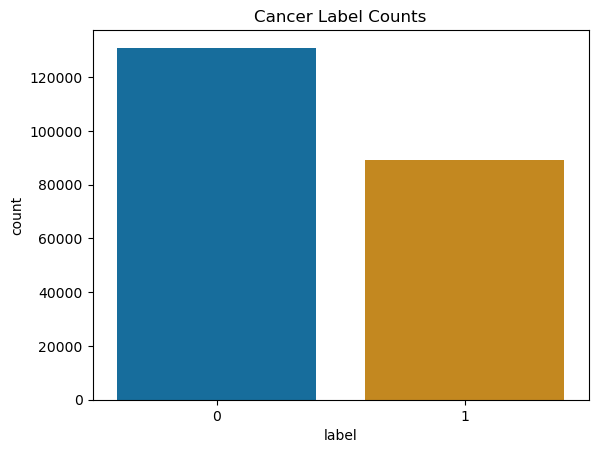

In [7]:
print(train_data['label'].value_counts())
sns.countplot(x=train_data['label'], palette='colorblind').set(title='Cancer Label Counts');

<AxesSubplot:title={'center':'Category Images'}, ylabel='label'>

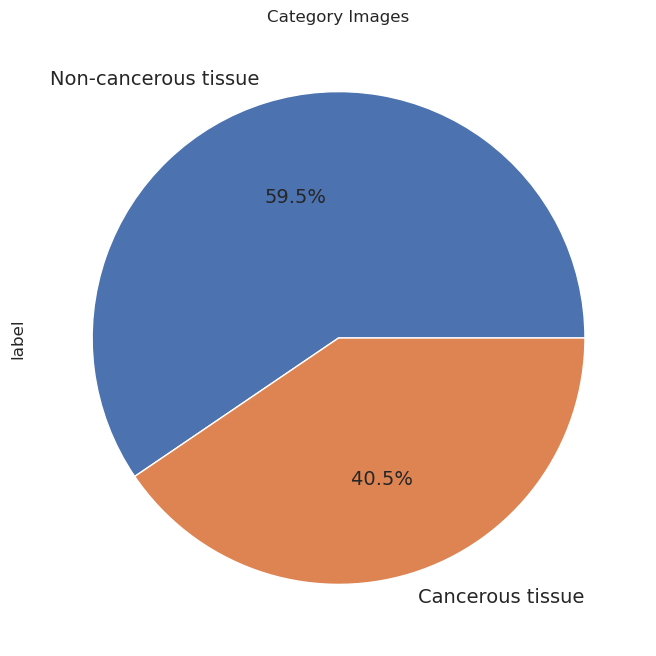

In [8]:
sns.set(style='whitegrid')
pie_chart=pd.DataFrame(train_data['label'].replace(0,'Non-cancerous tissue').replace(1,'Cancerous tissue').value_counts())
pie_chart.reset_index(inplace=True)
pie_chart.plot(kind='pie', title='Category Images',y = 'label', 
             autopct='%1.1f%%', shadow=False, labels=pie_chart['index'], legend = False, fontsize=14, figsize=(18,8))

#### Visualize images from data

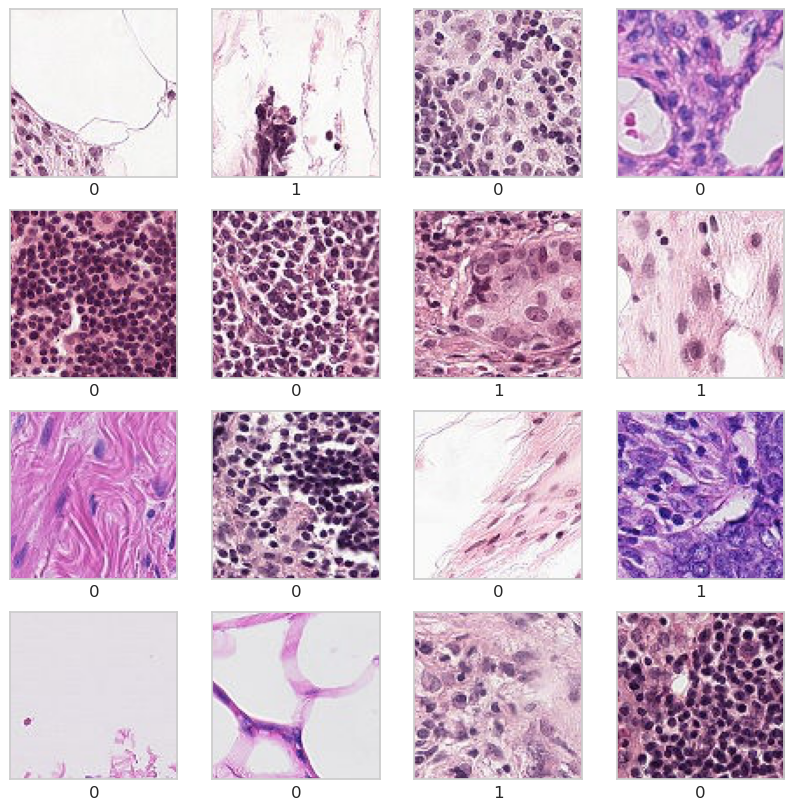

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i, axis in enumerate(ax.flat):
    file = str(train_path + train_data.id[i] + '.tif')
    image = io.imread(file)
    axis.imshow(image)
    axis.set(xticks=[], yticks=[], xlabel = train_data.label[i]);

In [10]:
# BATCH_SIZE
BATCH_SIZE = 256

In [11]:
# prepare data for training
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

# randomly shuffle training data
train_data = shuffle(train_data, random_state=seed)

In [12]:
# normalize data and split into training and test sets
datagen = ImageDataGenerator(rescale=1./200., validation_split=0.20)

In [13]:
# training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=seed,
    class_mode="binary",
    target_size=(64,64))  

Found 176020 validated image filenames belonging to 2 classes.


In [14]:
# generate validation data
test_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=seed,
    class_mode="binary",
    target_size=(64,64))  

Found 44005 validated image filenames belonging to 2 classes.


In [15]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

### Model

In [16]:
ROC_1 = tf.keras.metrics.AUC()


with strategy.scope():
    
    #model design
    model1 = Sequential()
    
    model1.add(Conv2D(filters=16, kernel_size=(3,3)))
    model1.add(Conv2D(filters=16, kernel_size=(3,3)))
    model1.add(MaxPooling2D(pool_size=(2,2)))

    model1.add(Conv2D(filters=32, kernel_size=(3,3)))
    model1.add(Conv2D(filters=32, kernel_size=(3,3)))
    model1.add(AveragePooling2D(pool_size=(2,2)))

    model1.add(Flatten())
    model1.add(Dense(1, activation='sigmoid'))
    
    #model input size
    model1.build(input_shape=(BATCH_SIZE, 64, 64, 3))        # original image = (96, 96, 3) 
    
    #compiling
    model1.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])
    
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (256, 62, 62, 16)         448       
                                                                 
 conv2d_1 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d (MaxPooling2D  (256, 30, 30, 16)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (256, 28, 28, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (256, 26, 26, 32)         9248      
                                                                 
 average_pooling2d (AverageP  (256, 13, 13, 32)        0         
 ooling2D)                                              

In [17]:
EPOCHS = 11

# train the model
history_model1 = model1.fit_generator(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = test_generator)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/11
688/688 [==============================] - 1990s 3s/step - loss: 0.6211 - accuracy: 0.6730 - auc: 0.7096 - val_loss: 0.5468 - val_accuracy: 0.7311 - val_auc: 0.7987
Epoch 2/11
688/688 [==============================] - 929s 1s/step - loss: 0.5542 - accuracy: 0.7303 - auc: 0.7839 - val_loss: 0.5210 - val_accuracy: 0.7513 - val_auc: 0.8150
Epoch 3/11
688/688 [==============================] - 963s 1s/step - loss: 0.5265 - accuracy: 0.7497 - auc: 0.8089 - val_loss: 0.5183 - val_accuracy: 0.7573 - val_auc: 0.8281
Epoch 4/11
688/688 [==============================] - 963s 1s/step - loss: 0.5069 - accuracy: 0.7642 - auc: 0.8248 - val_loss: 0.5014 - val_accuracy: 0.7663 - val_auc: 0.8413
Epoch 5/11
688/688 [==============================] - 963s 1s/step - loss: 0.4957 - accuracy: 0.7713 - auc: 0.8336 - val_loss: 0.4872 - val_accuracy: 0.7765 - val_auc: 0.8401
Epoch 6/11
688/688 [==============================] - 963s 1s/step - loss: 0.4870 - accuracy: 0.7777 - auc: 0.8400 - val_los

In [18]:
history_model1.history

{'loss': [0.6210611462593079,
  0.5542153120040894,
  0.5264657139778137,
  0.506904125213623,
  0.49566683173179626,
  0.48698949813842773,
  0.4793872833251953,
  0.4726245701313019,
  0.4674803614616394,
  0.46167951822280884,
  0.4565288722515106],
 'accuracy': [0.6730371713638306,
  0.7303374409675598,
  0.7497386932373047,
  0.7642483711242676,
  0.7713441848754883,
  0.7777127623558044,
  0.7810248732566833,
  0.7849505543708801,
  0.7889160513877869,
  0.7917622923851013,
  0.79521644115448],
 'auc': [0.7095999121665955,
  0.7838937640190125,
  0.808924674987793,
  0.824823260307312,
  0.8336220979690552,
  0.8399798274040222,
  0.845414400100708,
  0.8503086566925049,
  0.8539767265319824,
  0.8576104640960693,
  0.861217200756073],
 'val_loss': [0.5468248724937439,
  0.5210327506065369,
  0.518271803855896,
  0.5013836026191711,
  0.4871859848499298,
  0.4648953676223755,
  0.4711701273918152,
  0.4702359735965729,
  0.48388671875,
  0.49297255277633667,
  0.4526257812976837]

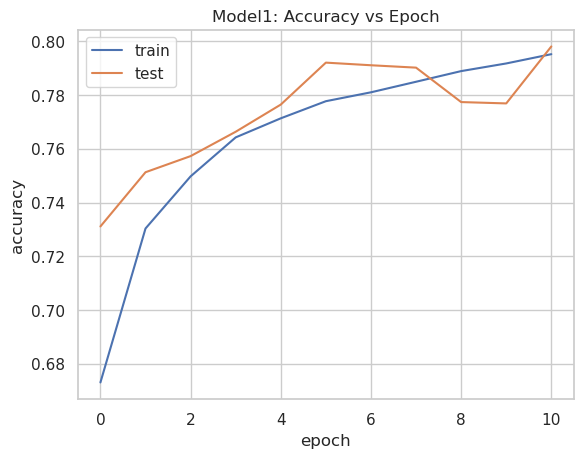

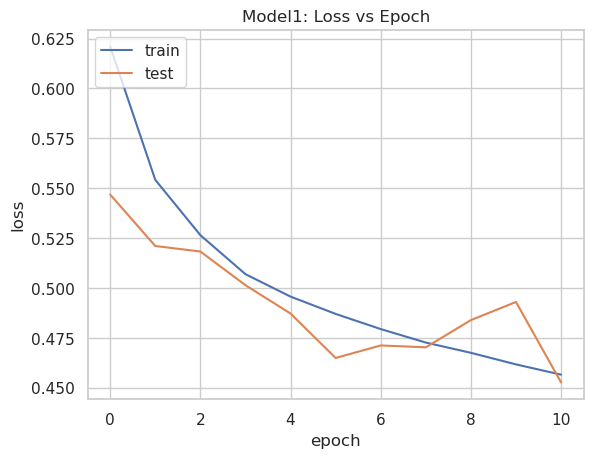

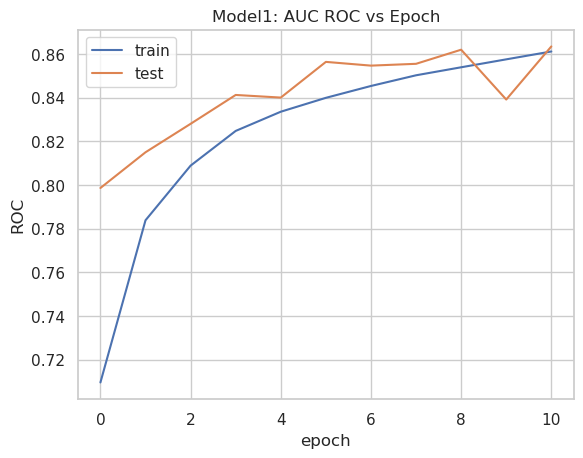

In [19]:
# plot model accuracy per epoch 
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model1: Accuracy vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model1: Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

# plot model ROC per epoch
plt.plot(history_model1.history['auc'])
plt.plot(history_model1.history['val_auc'])
plt.title('Model1: AUC ROC vs Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

In [20]:
ROC_2 = tf.keras.metrics.AUC()

with strategy.scope():
    
    #create model
    model2 = Sequential()
    
    model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.1))
    
    model2.add(BatchNormalization())
    model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model2.add(AveragePooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.1))
    
    model2.add(BatchNormalization())
    model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model2.add(Flatten())
    model2.add(Dense(1, activation='sigmoid'))
    
    #build model by input size
    model2.build(input_shape=(BATCH_SIZE, 64, 64, 3))       # original image = (96, 96, 3) 
    
    
    adam_optimizer = Adam(learning_rate=0.0001)
    model2.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)


model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (256, 62, 62, 16)         448       
                                                                 
 conv2d_5 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (256, 30, 30, 16)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (256, 30, 30, 16)         0         
                                                                 
 batch_normalization (BatchN  (256, 30, 30, 16)        64        
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (256, 28, 28, 32)        

In [21]:
EPOCHS = 11

# train model
history_model2 = model2.fit_generator(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = test_generator)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/11
688/688 [==============================] - 1074s 2s/step - loss: 0.4620 - accuracy: 0.7864 - auc_1: 0.8560 - val_loss: 0.4910 - val_accuracy: 0.7802 - val_auc_1: 0.8622
Epoch 2/11
688/688 [==============================] - 1064s 2s/step - loss: 0.3978 - accuracy: 0.8257 - auc_1: 0.8956 - val_loss: 0.5425 - val_accuracy: 0.7797 - val_auc_1: 0.9027
Epoch 3/11
688/688 [==============================] - 1012s 1s/step - loss: 0.3797 - accuracy: 0.8353 - auc_1: 0.9058 - val_loss: 0.3995 - val_accuracy: 0.8322 - val_auc_1: 0.9129
Epoch 4/11
688/688 [==============================] - 1052s 2s/step - loss: 0.3666 - accuracy: 0.8419 - auc_1: 0.9129 - val_loss: 0.4452 - val_accuracy: 0.8203 - val_auc_1: 0.9091
Epoch 5/11
688/688 [==============================] - 1050s 2s/step - loss: 0.3546 - accuracy: 0.8472 - auc_1: 0.9190 - val_loss: 0.5009 - val_accuracy: 0.8105 - val_auc_1: 0.9141
Epoch 6/11
688/688 [==============================] - 1041s 2s/step - loss: 0.3437 - accuracy: 0.851

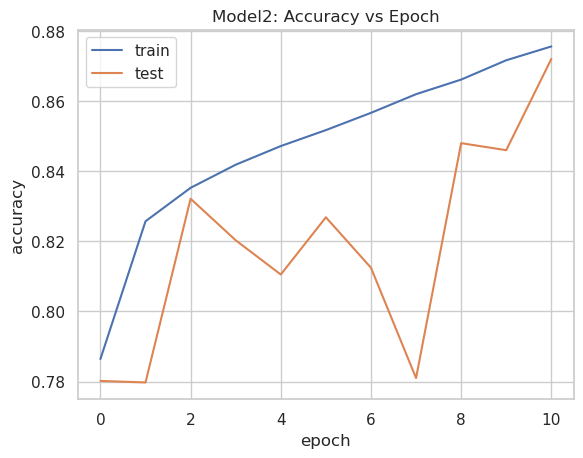

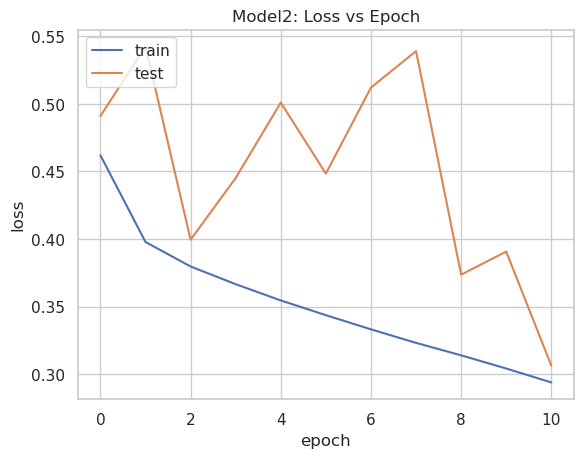

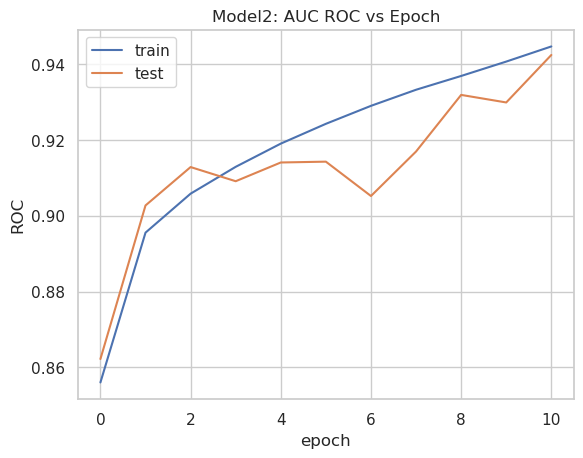

In [22]:
# graph loss
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model2: Accuracy vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])
plt.title('Model2: Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

# plot model ROC per epoch
plt.plot(history_model2.history['auc_1'])
plt.plot(history_model2.history['val_auc_1'])
plt.title('Model2: AUC ROC vs Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

In [23]:
# preparing test data
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [24]:
#creating predictions

predictions = model2.predict(test_generator, verbose=1)

57458/57458 [==============================] - 529s 9ms/step


In [25]:
#create submission dataframe
predictions = np.transpose(predictions)[0]
dataframeSubmit = pd.DataFrame()
dataframeSubmit['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
dataframeSubmit['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
dataframeSubmit.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [26]:
dataframeSubmit['label'].value_counts()

0    36295
1    21163
Name: label, dtype: int64

<AxesSubplot:title={'center':'Image Classification for Submission'}, ylabel='label'>

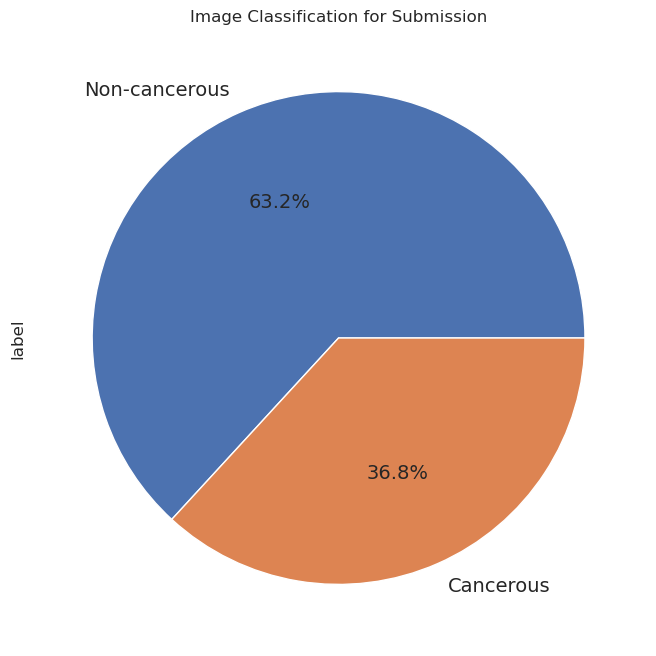

In [27]:
#Submission label percentage
sns.set(style='whitegrid')
pie_chart=pd.DataFrame(dataframeSubmit['label'].replace(0,'Non-cancerous').replace(1,'Cancerous').value_counts())
pie_chart.reset_index(inplace=True)
pie_chart.plot(kind='pie', title='Image Classification for Submission',y = 'label', 
             autopct='%1.1f%%', shadow=False, labels=pie_chart['index'], legend = False, fontsize=14, figsize=(18,8))

In [28]:
#Competition Submission
dataframeSubmit.to_csv('csvForSubmission.csv', index=False)

#### Conclusion
CNN network model works very well with small training dataset.
With image normalization, less compution will be required. 
Regulation with dropout and batch normalization resolved overfitting problems.
Futher augmentation techniques like resizing, flipping, rotating, cropping, padding, can help to address issues like overfitting and data scarcity, and they make the model robust with better performance.
Overall the model performed fairly accurate predictions. 
There are a few ways by which we can try to make the models better. 
We could try to train the model with augmented images by flipping or zooming in/out, etc.
We could use more epochs that woud allow the model to learn better, but we need to make sure that we don't overfit the data.